# Predicting Precipitation in San Jose, CA - Data Cleaning
The goal of this project will be to predict the chance of precipitation in San Jose using various weather features. That dataset is taken from the [NOAA](https://www.ncdc.noaa.gov/data-access/quick-links#loc-clim). I will use a 
decision tree as well as a random forest model and compare which model perform better.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists
import warnings
warnings.filterwarnings('ignore')

import helpers as hp
from config import usr, pwd, url, port, db, table

%matplotlib inline

## Load Dataset
Load dataset from csv file.

In [2]:
df = pd.read_csv('./data/san_jose_weather.csv', encoding='latin')

## Data Cleaning
Copy `DataFrame` to a new variable to preserve the intial, raw dataset.

In [3]:
df_clean = df.copy()

Set index to _DATE_.

In [4]:
df_clean['DATE'] = pd.to_datetime(df_clean['DATE'])
df_clean.set_index(['DATE'], inplace=True)

In [5]:
df.columns.tolist()

['STATION',
 'DATE',
 'REPORT_TYPE',
 'SOURCE',
 'AWND',
 'BackupDirection',
 'BackupDistance',
 'BackupDistanceUnit',
 'BackupElements',
 'BackupElevation',
 'BackupElevationUnit',
 'BackupEquipment',
 'BackupLatitude',
 'BackupLongitude',
 'BackupName',
 'CDSD',
 'CLDD',
 'DSNW',
 'DailyAverageDewPointTemperature',
 'DailyAverageDryBulbTemperature',
 'DailyAverageRelativeHumidity',
 'DailyAverageSeaLevelPressure',
 'DailyAverageStationPressure',
 'DailyAverageWetBulbTemperature',
 'DailyAverageWindSpeed',
 'DailyCoolingDegreeDays',
 'DailyDepartureFromNormalAverageTemperature',
 'DailyHeatingDegreeDays',
 'DailyMaximumDryBulbTemperature',
 'DailyMinimumDryBulbTemperature',
 'DailyPeakWindDirection',
 'DailyPeakWindSpeed',
 'DailyPrecipitation',
 'DailySnowDepth',
 'DailySnowfall',
 'DailySustainedWindDirection',
 'DailySustainedWindSpeed',
 'DailyWeather',
 'HDSD',
 'HTDD',
 'HeavyFog',
 'HourlyAltimeterSetting',
 'HourlyDewPointTemperature',
 'HourlyDryBulbTemperature',
 'HourlyPrec

### Daily columns
Only select the Daily columns.

In [6]:
daily_columns = [x for x in df_clean.columns.tolist() if 'Daily' in x]
df_clean = df_clean.loc[:, daily_columns].copy()

### Sunrise/Sunset
Add sunrise and sunset back to `df_clean`.

In [7]:
df_clean['Sunrise'] = df['Sunrise'].values
df_clean['Sunset'] = df['Sunset'].values

### Precipitation
The values in the precipitation column are strings. If there is a 'T' this indicates that there were trace amounts of precipitation. I want this column to be floats. So, I will convert each 'T' value to the minimum measurable value of '0.01' and then convert all values to floats.

In [8]:
df_clean['DailyPrecipitation'] = df_clean['DailyPrecipitation'].apply(lambda x: 0.01 if x == 'T' else float(x))

### Empty Rows

In [9]:
print(f'Dataset length: {len(df_clean)}')
print(f'Days in dataset: {5*365}')

Dataset length: 50042
Days in dataset: 1825


This dataset is 50042 rows long, but there are only 1825 days in this time period. I will remove any empty row so as to include only daily values. But, before doing this, I will backfill missing values for _Sunset_ and _Sunrise_ so that I do not loose these values.

In [10]:
df_clean['Sunrise'].fillna(method='bfill', inplace=True)
df_clean['Sunset'].fillna(method='bfill', inplace=True)

In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50042 entries, 2014-01-01 00:53:00 to 2018-12-31 23:59:00
Data columns (total 22 columns):
DailyAverageDewPointTemperature               1822 non-null float64
DailyAverageDryBulbTemperature                1820 non-null float64
DailyAverageRelativeHumidity                  1822 non-null float64
DailyAverageSeaLevelPressure                  1821 non-null float64
DailyAverageStationPressure                   1823 non-null float64
DailyAverageWetBulbTemperature                1822 non-null float64
DailyAverageWindSpeed                         1824 non-null float64
DailyCoolingDegreeDays                        1820 non-null float64
DailyDepartureFromNormalAverageTemperature    1820 non-null float64
DailyHeatingDegreeDays                        1820 non-null float64
DailyMaximumDryBulbTemperature                1823 non-null float64
DailyMinimumDryBulbTemperature                1820 non-null float64
DailyPeakWindDirection                  

In [12]:
df_clean = df_clean[df_clean['DailyPeakWindDirection'].notnull()].copy()

### Continuous and Categorical Variables
All variables are continous, except for _DailyWeather_.

In [13]:
all_continous_variables = df_clean.columns.tolist()
variables_to_remove = ['DailyWeather', 'Sunrise', 'Sunset']
for var in variables_to_remove:
    all_continous_variables.remove(var)
print(all_continous_variables)

['DailyAverageDewPointTemperature', 'DailyAverageDryBulbTemperature', 'DailyAverageRelativeHumidity', 'DailyAverageSeaLevelPressure', 'DailyAverageStationPressure', 'DailyAverageWetBulbTemperature', 'DailyAverageWindSpeed', 'DailyCoolingDegreeDays', 'DailyDepartureFromNormalAverageTemperature', 'DailyHeatingDegreeDays', 'DailyMaximumDryBulbTemperature', 'DailyMinimumDryBulbTemperature', 'DailyPeakWindDirection', 'DailyPeakWindSpeed', 'DailyPrecipitation', 'DailySnowDepth', 'DailySnowfall', 'DailySustainedWindDirection', 'DailySustainedWindSpeed']


### Missing Values
#### Continuous variables
For snow variables set missing values to zero.

In [14]:
snow_variables = ['DailySnowDepth', 'DailySnowfall']
for var in snow_variables:
    df_clean[var].fillna(0, inplace=True)

For the additional continous variables, I will use interpolation to fill the missing values.

In [15]:
non_snow_variables = df_clean.columns.tolist()
variables_to_remove = ['DailyWeather', 'DailySnowDepth', 'DailySnowfall', 'Sunrise', 'Sunset']
for var in variables_to_remove:
    non_snow_variables.remove(var)

Before applying interpolation, let's view the time series for each of these continous variables.

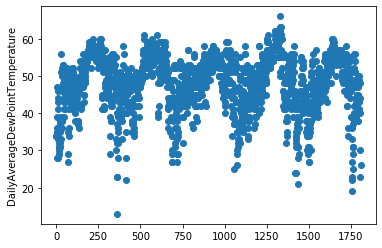

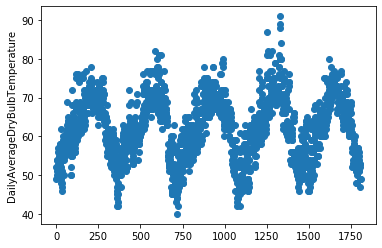

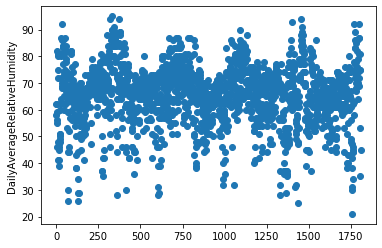

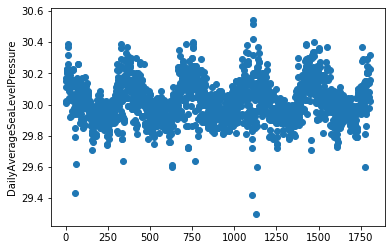

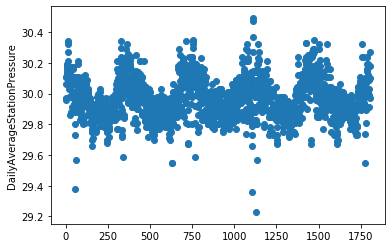

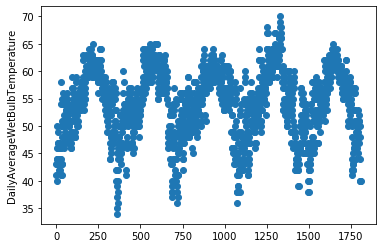

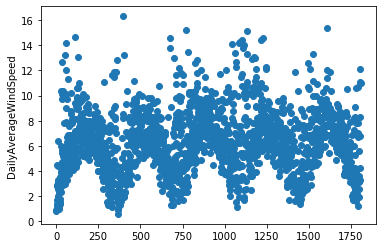

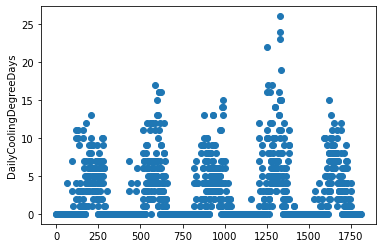

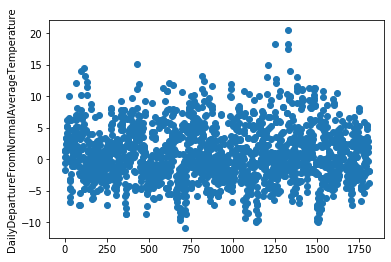

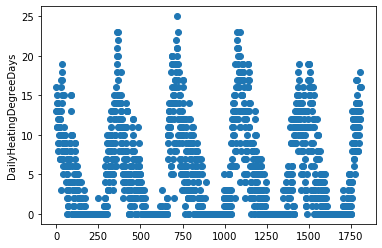

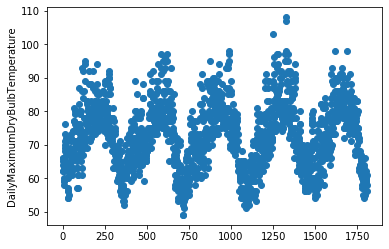

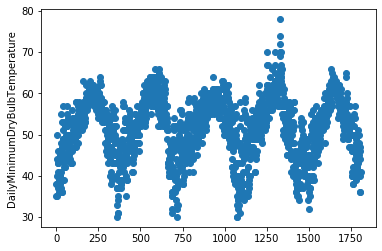

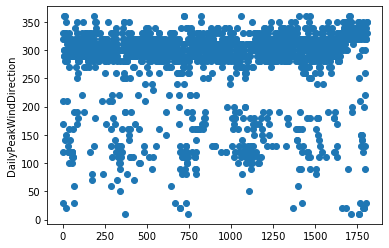

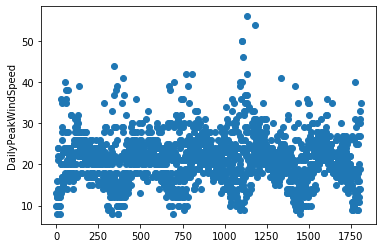

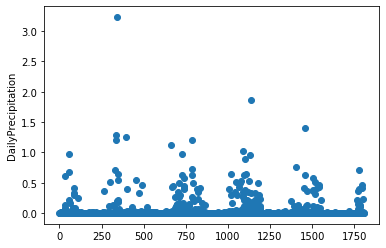

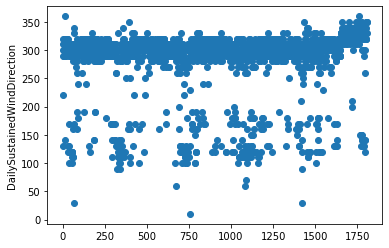

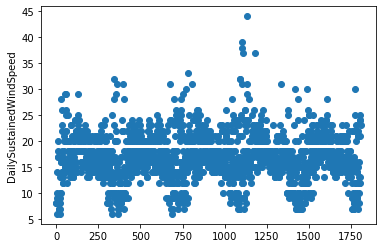

In [16]:
for column in df_clean.loc[:, non_snow_variables].columns:
    plt.scatter(np.arange(len(df_clean)), df_clean[column])
    plt.ylabel(column)
    plt.show()

In [17]:
hp.find_na_columns(df_clean.loc[:, non_snow_variables], display_fractions=True)

Variables with missing values and their fraction of missing values:
DailyAverageDewPointTemperature               0.001660
DailyAverageDryBulbTemperature                0.002767
DailyAverageRelativeHumidity                  0.001660
DailyAverageSeaLevelPressure                  0.002214
DailyAverageStationPressure                   0.001107
DailyAverageWetBulbTemperature                0.001660
DailyAverageWindSpeed                         0.000553
DailyCoolingDegreeDays                        0.002767
DailyDepartureFromNormalAverageTemperature    0.002767
DailyHeatingDegreeDays                        0.002767
DailyMaximumDryBulbTemperature                0.001107
DailyMinimumDryBulbTemperature                0.002767
dtype: float64


**Observations:** For the remaining continous variables, there are only a few missing values (less than 1% for all variables). Also, the time series clearly show seasonality. Therefore, I will correct for the missing values using interpolation and setting the `method` flag to _time_.

In [18]:
df_clean.loc[:, non_snow_variables].interpolate(method='time', inplace=True)

#### Categorical variables
The categorical variable, _DailyWeather_ shows many missing values. I will replace these missing values with the string _Unknown_. During the modeling phase, I will analyze how to handle these unknown weather types.

In [19]:
df_clean['DailyWeather'].fillna('Unknown', inplace=True)

In [20]:
hp.find_na_columns(df_clean, display_fractions=True)

Variables with missing values and their fraction of missing values:
DailyAverageDewPointTemperature               0.001660
DailyAverageDryBulbTemperature                0.002767
DailyAverageRelativeHumidity                  0.001660
DailyAverageSeaLevelPressure                  0.002214
DailyAverageStationPressure                   0.001107
DailyAverageWetBulbTemperature                0.001660
DailyAverageWindSpeed                         0.000553
DailyCoolingDegreeDays                        0.002767
DailyDepartureFromNormalAverageTemperature    0.002767
DailyHeatingDegreeDays                        0.002767
DailyMaximumDryBulbTemperature                0.001107
DailyMinimumDryBulbTemperature                0.002767
dtype: float64


**Observations:** There are still missing values in the dataset. I will now remove any rows that contain missing values.

In [21]:
df_clean.dropna(inplace=True)

In [22]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1798 entries, 2014-01-01 23:59:00 to 2018-12-31 23:59:00
Data columns (total 22 columns):
DailyAverageDewPointTemperature               1798 non-null float64
DailyAverageDryBulbTemperature                1798 non-null float64
DailyAverageRelativeHumidity                  1798 non-null float64
DailyAverageSeaLevelPressure                  1798 non-null float64
DailyAverageStationPressure                   1798 non-null float64
DailyAverageWetBulbTemperature                1798 non-null float64
DailyAverageWindSpeed                         1798 non-null float64
DailyCoolingDegreeDays                        1798 non-null float64
DailyDepartureFromNormalAverageTemperature    1798 non-null float64
DailyHeatingDegreeDays                        1798 non-null float64
DailyMaximumDryBulbTemperature                1798 non-null float64
DailyMinimumDryBulbTemperature                1798 non-null float64
DailyPeakWindDirection                   

Now the dataset has been cleaned. I will save it to a SQL database.
## Save Dataset
Save cleaned dataset to a SQL database.

In [23]:
# Create the database if it doesn't exist
db_url = f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}"
if database_exists(db_url):
    pass
else:
    create_database(db_url)

In [24]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [25]:
df_clean.to_sql(name=table, con=engine, index=False, if_exists='replace')

In [26]:
engine.dispose()